In [1]:
import os
import pickle
import shutil
import pandas as pd
import numpy as np

In [2]:
MAIN_PATH = os.path.dirname(os.getcwd())
DATA_SUBPATH = '/data'
DATASET_PATH = MAIN_PATH + DATA_SUBPATH + '/unzip/WESAD'
UNPROCESSED_PATH = MAIN_PATH + DATA_SUBPATH + '/unprocessed/WESAD'

In [3]:
minfolder = 2
maxfolder = 18
folders = [f'S{i}' for i in range(minfolder, maxfolder)]
print(folders)

['S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17']


This process unpacking the zip files can take up to 3 minutes. Depending on the computational power available.

In [4]:
shutil.unpack_archive(MAIN_PATH + DATA_SUBPATH + '/WESAD.zip', MAIN_PATH + DATA_SUBPATH + '/unzip')

In [5]:
data_folders = []
for subfolder in folders:
    data_folders.append(f"{MAIN_PATH}{DATA_SUBPATH}/unzip/WESAD/{subfolder}/{subfolder}_E4_Data.zip")
print(data_folders)

['c:\\Users\\goert\\Documents\\GitHub\\Convolutional-Neural-Network-on-Electrodermal-Activity-for-Stress-Assessment/data/unzip/WESAD/S2/S2_E4_Data.zip', 'c:\\Users\\goert\\Documents\\GitHub\\Convolutional-Neural-Network-on-Electrodermal-Activity-for-Stress-Assessment/data/unzip/WESAD/S3/S3_E4_Data.zip', 'c:\\Users\\goert\\Documents\\GitHub\\Convolutional-Neural-Network-on-Electrodermal-Activity-for-Stress-Assessment/data/unzip/WESAD/S4/S4_E4_Data.zip', 'c:\\Users\\goert\\Documents\\GitHub\\Convolutional-Neural-Network-on-Electrodermal-Activity-for-Stress-Assessment/data/unzip/WESAD/S5/S5_E4_Data.zip', 'c:\\Users\\goert\\Documents\\GitHub\\Convolutional-Neural-Network-on-Electrodermal-Activity-for-Stress-Assessment/data/unzip/WESAD/S6/S6_E4_Data.zip', 'c:\\Users\\goert\\Documents\\GitHub\\Convolutional-Neural-Network-on-Electrodermal-Activity-for-Stress-Assessment/data/unzip/WESAD/S7/S7_E4_Data.zip', 'c:\\Users\\goert\\Documents\\GitHub\\Convolutional-Neural-Network-on-Electrodermal-Act

In [6]:
for folder, data_folder in zip(folders, data_folders):
    try:
        shutil.unpack_archive(data_folder, os.path.join(UNPROCESSED_PATH, f'{folder}'))
        print("Preparing folder:", folder)
    except shutil.ReadError:
        print(f"Skipping {data_folder} as it is not a zip file or missing.")

print("Finished unzipping and preparing files.")

Preparing folder: S2
Preparing folder: S3
Preparing folder: S4
Preparing folder: S5
Preparing folder: S6
Preparing folder: S7
Preparing folder: S8
Preparing folder: S9
Preparing folder: S10
Preparing folder: S11
Skipping c:\Users\goert\Documents\GitHub\Convolutional-Neural-Network-on-Electrodermal-Activity-for-Stress-Assessment/data/unzip/WESAD/S12/S12_E4_Data.zip as it is not a zip file or missing.
Preparing folder: S13
Preparing folder: S14
Preparing folder: S15
Preparing folder: S16
Preparing folder: S17
Finished unzipping and preparing files.


In [7]:
from scipy.signal import resample

def resample_signal(signal, source_rate, target_rate):
    # Calculate resampling ratio
    resampling_ratio = target_rate / source_rate
    
    # Calculate new length
    new_length = int(len(signal) * resampling_ratio)
    
    # Resample signal
    resampled_signal = resample(signal, new_length)

    return resampled_signal

In [8]:
import os
import pickle
import numpy as np
import pandas as pd
import numpy as np

# Define the source and destination paths
source_folder = DATASET_PATH
destination_folder = UNPROCESSED_PATH
target_rate = 4

def create_destination_folder(destination_folder, folder):
    # Create the destination folder if it doesn't exist
    destination_path = os.path.join(destination_folder, folder)
    os.makedirs(destination_path, exist_ok=True)
    return destination_path


# Iterate over the folders
for folder in folders:
    destination_path = create_destination_folder(destination_folder, folder)
        
    # Open the pickle file
    source_path = os.path.join(source_folder, folder, f'{folder}.pkl')
    if not os.path.exists(source_path):
        print(f"Skipping {source_path} as it does not exist.")
        continue
        
    with open(source_path, 'rb') as file:
        data = pickle.load(file, encoding='latin1')
        
        print('label of:' + str(data['label']))

         # Resample signals
        w_ax=data['signal']['wrist']['ACC'][0:,0]#[stress_to_plot]
        w_ay=data['signal']['wrist']['ACC'][0:,1]#[stress_to_plot]
        w_az=data['signal']['wrist']['ACC'][0:,2]#[stress_to_plot]
        w_bvp=data['signal']['wrist']['BVP'][:,0]#[stress_to_plot]
        w_eda=data['signal']['wrist']['EDA'][:,0]#[stress_to_plot]
        w_temp=data['signal']['wrist']['TEMP'][:,0]#[stress_to_plot]

        resampled_label = resample_signal(data['label'], 700, target_rate)
    	
        labels = data['label']
        downsampled_labels = labels[::700 // 4]
        print(len(downsampled_labels))

        
        print(f"Equated: {folder}")

        numpy_data1 = np.array([w_eda, w_temp, downsampled_labels]).T

        df = pd.DataFrame(data=numpy_data1, columns=["w_eda", "w_temp", "downsampled_labels"]) 

        # Save the data frame
        # Convert DataFrame to array
        array_data = df.to_numpy()

        # Save array as .npy file
        np.save(destination_path, array_data)
        print(f"Saved: {folder}")

label of:[0 0 0 ... 0 0 0]
24316
Equated: S2
Saved: S2
label of:[0 0 0 ... 0 0 0]
25972
Equated: S3
Saved: S3
label of:[0 0 0 ... 0 0 0]
25692
Equated: S4
Saved: S4
label of:[0 0 0 ... 0 0 0]
25032
Equated: S5
Saved: S5
label of:[0 0 0 ... 0 0 0]
28284
Equated: S6
Saved: S6
label of:[0 0 0 ... 0 0 0]
20952
Equated: S7
Saved: S7
label of:[0 0 0 ... 0 0 0]
21864
Equated: S8
Saved: S8
label of:[0 0 0 ... 0 0 0]
20892
Equated: S9
Saved: S9
label of:[0 0 0 ... 0 0 0]
21984
Equated: S10
Saved: S10
label of:[0 0 0 ... 0 0 0]
20932
Equated: S11
Saved: S11
Skipping c:\Users\goert\Documents\GitHub\Convolutional-Neural-Network-on-Electrodermal-Activity-for-Stress-Assessment/data/unzip/WESAD\S12\S12.pkl as it does not exist.
label of:[0 0 0 ... 0 0 0]
22148
Equated: S13
Saved: S13
label of:[0 0 0 ... 0 0 0]
22192
Equated: S14
Saved: S14
label of:[0 0 0 ... 0 0 0]
21008
Equated: S15
Saved: S15
label of:[0 0 0 ... 0 0 0]
22524
Equated: S16
Saved: S16
label of:[0 0 0 ... 0 0 0]
23680
Equated: S17
Sav

In [9]:
len(labels)

4144000

In [10]:
w_eda

array([2.015176, 2.012617, 2.001103, ..., 0.78717 , 0.784611, 0.783331])

In [11]:
df

,w_eda,w_temp,downsampled_labels
0,2.015176,33.39,0.0
1,2.012617,33.37,0.0
2,2.001103,33.37,0.0
3,2.030529,33.37,0.0
4,1.979353,33.37,0.0
...,...,...,...
23675,0.792287,31.81,0.0
23676,0.787170,31.81,0.0
23677,0.787170,31.81,0.0
23678,0.784611,31.81,0.0


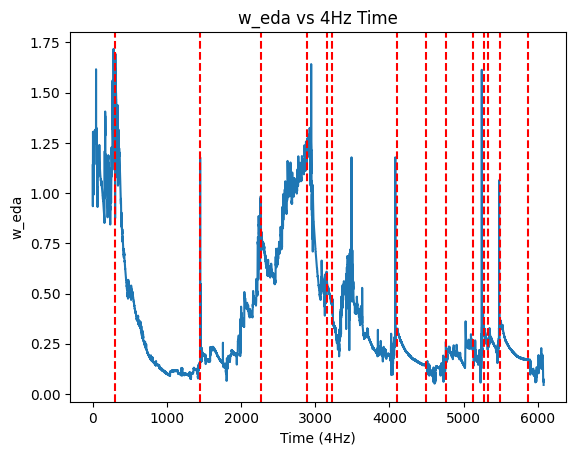

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file
data_path = 'C:/Users/goert/Documents/GitHub/Convolutional-Neural-Network-on-Electrodermal-Activity-for-Stress-Assessment/data/unprocessed/WESAD/S2/S2.csv'
df = pd.read_csv(data_path)

# Extract the columns
w_eda = df['w_eda']
labels = df['downsampled_labels']

# Calculate the time values
time = np.arange(len(w_eda)) / 4

# Plot the data
plt.plot(time, w_eda)

# Highlight label changes
prev_label = labels[0]
for i in range(1, len(labels)):
    if labels[i] != prev_label:
        plt.axvline(x=time[i], color='red', linestyle='--')
        prev_label = labels[i]


plt.xlabel('Time (4Hz)')
plt.ylabel('w_eda')
plt.title('w_eda vs 4Hz Time')
plt.show()


In [13]:
import pandas as pd
import pandas as pd
# Read the first file
file_eda = 'C:/Users/goert/Documents/GitHub/Convolutional-Neural-Network-on-Electrodermal-Activity-for-Stress-Assessment/data/unprocessed/WESAD/S2/EDA.csv'
df_eda = pd.read_csv(file_eda)

# Read the second file
file_pkl = 'C:/Users/goert/Documents/GitHub/Convolutional-Neural-Network-on-Electrodermal-Activity-for-Stress-Assessment/data/unprocessed/WESAD/S2/S2.csv'

# Merge the two dataframes
a = [file_eda, file_pkl]
files = [file for file in a]
df = pd.concat(map(pd.read_csv, files), ignore_index = True)

# Save the merged dataframe as a CSV file
df.to_csv('C:/Users/goert/Documents/GitHub/Convolutional-Neural-Network-on-Electrodermal-Activity-for-Stress-Assessment/data/merged_data.csv', index=False)
